# Retrieval of Bottom Temps from ERDDAP Dataset for distribution


In [1]:
import datetime
from erddapy import ERDDAP
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

#using xarray for bathymetry data read
import xarray as xa

In [42]:
#search and boundary parameters

server_url = 'http://akutan.pmel.noaa.gov:8080/erddap/'

deployments = []

constraints = {
    'time>=': '2010-01-01T00:00:00Z',
    'time<=': datetime.datetime.utcnow().strftime('%Y-%m-%dT00:00:00Z'),
    'depth>=': 55,
}

variables = ['latitude, longitude, temperature, time, depth, timeseries_id']


In [43]:
e = ERDDAP(server=server_url)
df_1 = pd.read_csv(e.get_search_url(response='csv', search_for='Mooring bs2 -gridded final -CTD'))
e = ERDDAP(server=server_url)
df_2 = pd.read_csv(e.get_search_url(response='csv', search_for='Mooring bsm2 -gridded final -CTD -Meteorological'))
df = pd.concat([df_1,df_2])


print(sorted(df['Dataset ID'].values))


['datasets_Mooring_00bsm2a_final', 'datasets_Mooring_00bsp2w_final', 'datasets_Mooring_01bs2c_final', 'datasets_Mooring_01bsm2a_final', 'datasets_Mooring_02bs2c_final', 'datasets_Mooring_02bsm2a_final', 'datasets_Mooring_03bs2a_final', 'datasets_Mooring_03bs2c_final', 'datasets_Mooring_03bsm2a_final', 'datasets_Mooring_04bs2c_final', 'datasets_Mooring_04bsm2a_final', 'datasets_Mooring_05bs2c_final', 'datasets_Mooring_05bsm2a_final', 'datasets_Mooring_06bs2c_final', 'datasets_Mooring_06bsm2a_final', 'datasets_Mooring_07bs2c_final', 'datasets_Mooring_07bsm2a_final', 'datasets_Mooring_08bs2c_final', 'datasets_Mooring_08bsm2a_final', 'datasets_Mooring_09bs2c_final', 'datasets_Mooring_09bsm2a_final', 'datasets_Mooring_09bsp2a_final', 'datasets_Mooring_10bs2c_final', 'datasets_Mooring_10bsm2a_final', 'datasets_Mooring_11bs2c_final', 'datasets_Mooring_11bsm2a_final', 'datasets_Mooring_12bs2c_final', 'datasets_Mooring_12bsm2a_final', 'datasets_Mooring_13bs2c_final', 'datasets_Mooring_13bsm2a_f

In [44]:
from requests.exceptions import HTTPError

dfs = {}
for dataset_id in sorted(df['Dataset ID'].values):
    print(dataset_id)
    try:
        d = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        d.dataset_id=dataset_id
        d.variables = variables
        d.constraints = constraints
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))

    try:
        df_m = d.to_pandas(
                    index_col='time (UTC)',
                    parse_dates=True,
                    skiprows=(1,)  # units information can be dropped.
                    )
        df_m.sort_index(inplace=True)
        df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
        
        #-9999 and 1e35 are missing values... but erddap doesn't catch the -9999 yet 
        #and some 1e35 are off a bit
        df_m['depth'][(df_m.depth == -9999)] = np.nan # only in pressure field
        dfs.update({dataset_id:df_m})
    except:
        pass


datasets_Mooring_00bsm2a_final
datasets_Mooring_00bsp2w_final
datasets_Mooring_01bs2c_final
datasets_Mooring_01bsm2a_final
datasets_Mooring_02bs2c_final
datasets_Mooring_02bsm2a_final
datasets_Mooring_03bs2a_final
datasets_Mooring_03bs2c_final
datasets_Mooring_03bsm2a_final
datasets_Mooring_04bs2c_final
datasets_Mooring_04bsm2a_final
datasets_Mooring_05bs2c_final
datasets_Mooring_05bsm2a_final
datasets_Mooring_06bs2c_final
datasets_Mooring_06bsm2a_final
datasets_Mooring_07bs2c_final
datasets_Mooring_07bsm2a_final
datasets_Mooring_08bs2c_final
datasets_Mooring_08bsm2a_final
datasets_Mooring_09bs2c_final
datasets_Mooring_09bsm2a_final
datasets_Mooring_09bsp2a_final
datasets_Mooring_10bs2c_final
datasets_Mooring_10bsm2a_final
datasets_Mooring_11bs2c_final
datasets_Mooring_11bsm2a_final
datasets_Mooring_12bs2c_final
datasets_Mooring_12bsm2a_final
datasets_Mooring_13bs2c_final
datasets_Mooring_13bsm2a_final
datasets_Mooring_14bs2c_final
datasets_Mooring_14bsm2a_final
datasets_Mooring_15bs2c

In [49]:
merged_dataset = pd.DataFrame()
for dataset in dfs:
    dfg = dfs[dataset].dropna().groupby('timeseries_id')
    print(list(dfs[dataset].dropna().groupby('timeseries_id').groups.keys()))
    name =  list(dfs[dataset].dropna().groupby('timeseries_id').groups.keys())[-1]
    if (not 'wcp' in name) and (not 'sg' in name):
        print(name)
        merged_dataset = pd.concat([merged_dataset,pd.DataFrame(dfs[dataset].dropna().groupby('timeseries_id').get_group(name))])
    else:
        name =  list(dfs[dataset].dropna().groupby('timeseries_id').groups.keys())[-2]
        merged_dataset = pd.concat([merged_dataset,pd.DataFrame(dfs[dataset].dropna().groupby('timeseries_id').get_group(name))])


['09bs2c_s37_0055m', '09bs2c_s37_0067m', '09bs2c_s39_0061m', '09bs2c_sc_0061m']
09bs2c_sc_0061m
['10bs2c_mt_0057m', '10bs2c_mt_0058m', '10bs2c_s37_0059m', '10bs2c_s37_0067m']
10bs2c_s37_0067m
['10bsm2a_s37_0062m', '10bsm2a_s39_0055m', '10bsm2a_s39_0060m']
10bsm2a_s39_0060m
['11bs2c_mt_0060m', '11bs2c_mt_0061m', '11bs2c_s37_0055m', '11bs2c_s37_0061m', '11bs2c_s37_0067m']
11bs2c_s37_0067m
['11bsm2a_mt_0055m', '11bsm2a_mt_0056m', '11bsm2a_s39_0060m']
11bsm2a_s39_0060m
['12bs2c_s37_0060m', '12bs2c_s37_0067m', '12bs2c_s39_0055m']
12bs2c_s39_0055m
['12bsm2a_s37_0061m', '12bsm2a_s39_0055m', '12bsm2a_s39_0060m']
12bsm2a_s39_0060m
['13bs2c_s37_0055m']
13bs2c_s37_0055m
['13bsm2a_mt_0055m', '13bsm2a_mt_0056m', '13bsm2a_s37_0061m', '13bsm2a_s39_0060m']
13bsm2a_s39_0060m
['14bs2c_mt4008_0060m', '14bs2c_mt4031_0060m']
14bs2c_mt4031_0060m
['14bsm2a_mt4032_0055m', '14bsm2a_mt4033_0055m', '14bsm2a_s37_0061m', '14bsm2a_s39_0060m']
14bsm2a_s39_0060m
['15bs2c_mt3180_0060m', '15bs2c_mt3202_0060m']
15bs2c_m

In [55]:
#append 2019-2021
df_new = pd.read_csv('/Users/bell/Downloads/19bs2c_s39_0060m.csv',parse_dates=True,index_col='time')

AttributeError: 'DataFrame' object has no attribute 'dt'

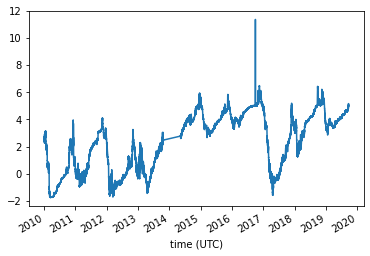

In [70]:
merged_dataset.temperature.plot()
merged_dataset.resample('1D').mean().temperature.plot()
df_new.resample('1D').mean().temperature.plot()

In [16]:
merged_dataset.to_csv('M5_BottomTemp.csv')
merged_dataset.resample('1H').mean().to_csv('M5_BottomTemp_hourly.csv')
tmp = merged_dataset.resample('1H').mean()
tmp[tmp.index.hour == 12].drop(['depth','latitude','longitude'],axis=1).to_csv('10ckp2a_BottomTemp_12utc.csv')

In [80]:
merged_dataset.index = merged_dataset.index.tz_localize(None)
pd.concat([merged_dataset.resample('1D').mean().temperature,df_new.resample('1D').mean().temperature]).to_csv('M2_BottomTemp_daily.csv')


In [81]:
df_new2=pd.read_csv('M2_BottomTemp_daily.csv',parse_dates=True,index_col='Unnamed: 0')

<AxesSubplot:>

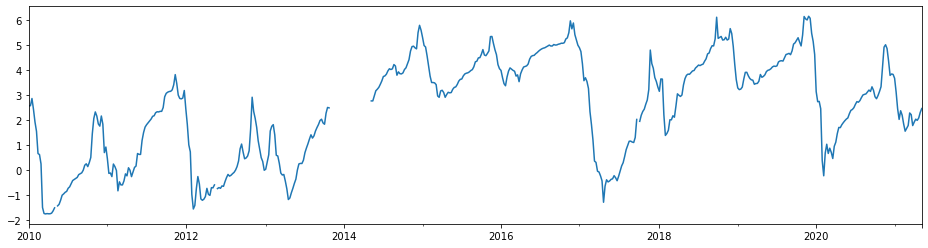

In [86]:
df_new2.resample('1w').mean().temperature.plot(figsize=(16,4))